# Import the necessary libraries

In [1]:
#Ref https://github.com/hkproj/quantization-notes/tree/main
#Ref https://pytorch.org/docs/stable/quantization-support.html
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np

# Utility Functions

In [2]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    model_size = os.path.getsize("temp_delme.p")/1e3
    print('Size (KB):', model_size)
    os.remove('temp_delme.p')
    return model_size

# Load the MNIST dataset

In [3]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = "cpu"

# Define the non-quantized model

In [5]:
class FCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size_1=100, hidden_size_2=100, output_size=10):
        super(FCNN,self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# Hyperparameters and setting the model

In [6]:
# Hyperparameters
input_size = 28 * 28  # MNIST image size
hidden_size_1 = 100
hidden_size_2 = 100
output_size = 10
batch_size = 10
learning_rate = 0.001
num_epochs = 1

In [7]:
model = FCNN(input_size, hidden_size_1, hidden_size_2, output_size).to(device)

# Train the model

In [8]:
def train(train_loader, model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
            loss.backward()
            optimizer.step()

In [9]:
MODEL_FILENAME = 'FCNN_ptq.pt'
if Path(MODEL_FILENAME).exists():
    model.load_state_dict(torch.load(MODEL_FILENAME))
    print('Loaded model from disk')
else:
    train(train_loader, model, epochs=num_epochs)
    # Save the model to disk
    torch.save(model.state_dict(), MODEL_FILENAME)

Loaded model from disk


In [10]:
def test(test_loader,model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            #print('Predicted (Pruned):', predicted.cpu().tolist())
            #print('Actual           :', labels.cpu().tolist())
            for idx, i in enumerate(outputs):
                if torch.argmax(i) == labels[idx]:
                    correct +=1
                total +=1
            #break  # Display predictions for the first batch
    print(f'Accuracy: {round(correct/total, 3)}')

# Print weights and size of the model before quantization

In [11]:
# Print the weights matrix of the model before quantization
print('Weights before quantization')
print(model.linear1.weight)
print(model.linear1.weight.dtype)

Weights before quantization
Parameter containing:
tensor([[ 0.0005,  0.0199, -0.0286,  ...,  0.0227,  0.0045,  0.0028],
        [-0.0224, -0.0176, -0.0131,  ..., -0.0229, -0.0086, -0.0326],
        [ 0.0304,  0.0654,  0.0173,  ...,  0.0302,  0.0517,  0.0586],
        ...,
        [ 0.0586,  0.0623,  0.0277,  ...,  0.0223,  0.0416,  0.0046],
        [-0.0069,  0.0012,  0.0332,  ...,  0.0135,  0.0136,  0.0131],
        [ 0.0016, -0.0037, -0.0179,  ...,  0.0186, -0.0307, -0.0106]],
       requires_grad=True)
torch.float32


In [12]:
print('Size of the model before quantization')
print_size_of_model(model)

Size of the model before quantization
Size (KB): 360.998


360.998

# Insert min-max observers in the model

In [13]:
class QuantizedFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size_1=100, hidden_size_2=100, output_size=10):
        super(QuantizedFCNN,self).__init__()
        self.quant = torch.quantization.QuantStub() #Quantize stub module, before calibration, this is same as an observer,
        self.linear1 = nn.Linear(input_size, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()
        self.dequant = torch.quantization.DeQuantStub() #Dequantize stub module, before calibration

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.quant(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.dequant(x)
        return x

In [14]:
model_q = QuantizedFCNN().to(device)
# Copy weights from unquantized model
model_q.load_state_dict(model.state_dict())
model_q.eval()

model_q.qconfig = torch.ao.quantization.default_qconfig # Default qconfig configuration.
model_q = torch.ao.quantization.prepare(model_q) # Insert observers
model_q

QuantizedFCNN(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear1): Linear(
    in_features=784, out_features=100, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear2): Linear(
    in_features=100, out_features=100, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU()
  (dequant): DeQuantStub()
)

# Calibrate the model using the test set

In [15]:
print(f'Check statistics of the various layers')
model_q

Check statistics of the various layers


QuantizedFCNN(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear1): Linear(
    in_features=784, out_features=100, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear2): Linear(
    in_features=100, out_features=100, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (relu): ReLU()
  (dequant): DeQuantStub()
)

# Quantize the model using the statistics collected

In [16]:
test(test_loader,model_q)

Accuracy: 0.959


In [17]:
model_q = torch.ao.quantization.convert(model_q) #Apply quantization

In [18]:
print(f'Check statistics of the various layers')
model_q

Check statistics of the various layers


QuantizedFCNN(
  (quant): Quantize(scale=tensor([0.0256]), zero_point=tensor([17]), dtype=torch.quint8)
  (linear1): QuantizedLinear(in_features=784, out_features=100, scale=0.7031587362289429, zero_point=73, qscheme=torch.per_tensor_affine)
  (linear2): QuantizedLinear(in_features=100, out_features=100, scale=0.38912928104400635, zero_point=62, qscheme=torch.per_tensor_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=0.3509964346885681, zero_point=71, qscheme=torch.per_tensor_affine)
  (relu): ReLU()
  (dequant): DeQuantize()
)

# Print weights of the model after quantization

In [19]:
# Print the weights matrix of the model after quantization
print('Weights after quantization')
print(torch.int_repr(model_q.linear1.weight()))

Weights after quantization
tensor([[ 0,  4, -6,  ...,  5,  1,  1],
        [-5, -4, -3,  ..., -5, -2, -7],
        [ 7, 15,  4,  ...,  7, 12, 13],
        ...,
        [13, 14,  6,  ...,  5,  9,  1],
        [-2,  0,  7,  ...,  3,  3,  3],
        [ 0, -1, -4,  ...,  4, -7, -2]], dtype=torch.int8)


# Compare the dequantized weights and the original weights

In [20]:
print('Original weights: ')
print(model.linear1.weight)
print('')
print(f'Dequantized weights: ')
print(torch.dequantize(model_q.linear1.weight()))
print('')

Original weights: 
Parameter containing:
tensor([[ 0.0005,  0.0199, -0.0286,  ...,  0.0227,  0.0045,  0.0028],
        [-0.0224, -0.0176, -0.0131,  ..., -0.0229, -0.0086, -0.0326],
        [ 0.0304,  0.0654,  0.0173,  ...,  0.0302,  0.0517,  0.0586],
        ...,
        [ 0.0586,  0.0623,  0.0277,  ...,  0.0223,  0.0416,  0.0046],
        [-0.0069,  0.0012,  0.0332,  ...,  0.0135,  0.0136,  0.0131],
        [ 0.0016, -0.0037, -0.0179,  ...,  0.0186, -0.0307, -0.0106]],
       requires_grad=True)

Dequantized weights: 
tensor([[ 0.0000,  0.0180, -0.0269,  ...,  0.0224,  0.0045,  0.0045],
        [-0.0224, -0.0180, -0.0135,  ..., -0.0224, -0.0090, -0.0314],
        [ 0.0314,  0.0673,  0.0180,  ...,  0.0314,  0.0539,  0.0584],
        ...,
        [ 0.0584,  0.0628,  0.0269,  ...,  0.0224,  0.0404,  0.0045],
        [-0.0090,  0.0000,  0.0314,  ...,  0.0135,  0.0135,  0.0135],
        [ 0.0000, -0.0045, -0.0180,  ...,  0.0180, -0.0314, -0.0090]])



(array([1.0000e+01, 3.5000e+01, 1.1000e+02, 5.0900e+02, 3.0720e+03,
        2.1779e+04, 4.7272e+04, 5.1490e+03, 4.5200e+02, 1.2000e+01]),
 array([-0.57012123, -0.47764486, -0.38516852, -0.29269215, -0.2002158 ,
        -0.10773945, -0.01526309,  0.07721327,  0.16968963,  0.26216596,
         0.35464233]),
 <BarContainer object of 10 artists>)

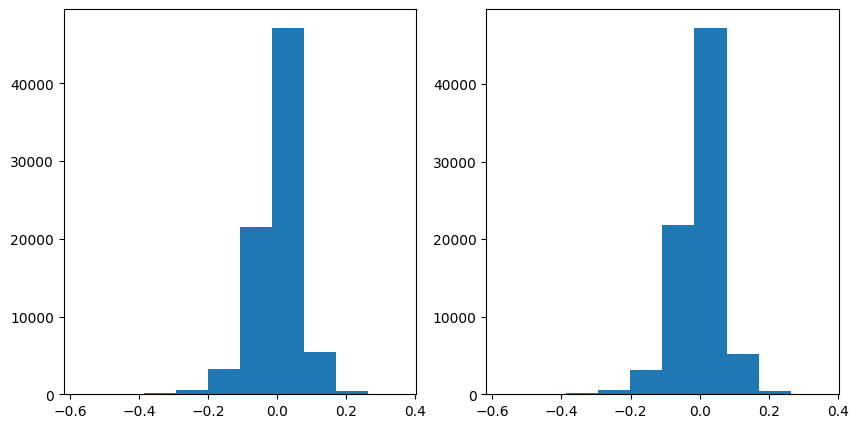

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(model.linear1.weight.cpu().detach().numpy().flatten())
plt.subplot(1,2,2)
plt.hist(torch.dequantize(model_q.linear1.weight()).cpu().detach().numpy().flatten())

# Print size and accuracy of the quantized model

In [22]:
print('Size of the model before quantization')
model_size = print_size_of_model(model)
print('Size of the model after quantization')
modelq_size = print_size_of_model(model_q)
print('Compression Ratio: ',np.round(model_size/modelq_size))

Size of the model before quantization
Size (KB): 360.998
Size of the model after quantization
Size (KB): 95.394
Compression Ratio:  4.0


In [23]:
print('Testing the model before quantization')
test(test_loader, model)
print('Testing the model after quantization')
test(test_loader, model_q)

Testing the model before quantization
Accuracy: 0.959
Testing the model after quantization
Accuracy: 0.96
